# Assignment 3

## Id numbers and names

1.   313326985 Shahar Shcheranski
2.   206172686 Sarit Hollander

# Imports

In [ ]:
!pip install pretty_midi

In [ ]:
!pip install gensim

!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import as_strided
import random
import tensorflow as tf
import os
import nltk
from nltk.tokenize import word_tokenize
from functools import lru_cache
import pretty_midi
from gensim import models
import re
import joblib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda, Input, Embedding, Concatenate, LSTM, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/shcheran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Loading data

In [ ]:
url = "https://drive.google.com/file/d/1ofMPioEKgX_gCksY-S1OCYCD-p3nSt5y/view?usp=sharing"

In [ ]:
!gdown --id 1ofMPioEKgX_gCksY-S1OCYCD-p3nSt5y

/home/shcheran/.conda/envs/dl-env/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ofMPioEKgX_gCksY-S1OCYCD-p3nSt5y
To: /sise/home/shcheran/deep-learning/assignment3/Archive.zip
100%|██████████████████████████████████████| 7.42M/7.42M [00:00<00:00, 11.5MB/s]


In [ ]:
!unzip -q ./Archive.zip

### Load data from the csv files

In [ ]:
cols_names = ['Singer', 'Song Name', 'Lyrics']

# Load the train set
df_train = pd.read_csv('./Archive/lyrics_train_set.csv', header=None, usecols=[0,1,2], names=cols_names)
df_train

,Singer,Song Name,Lyrics
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...
...,...,...,...
610,don henley,dirty laundry,i make my living off the evening news & just g...
611,don henley,new york minute,harry got up & dressed all in black & went dow...
612,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...
613,goldfinger,mable,i met her sunday that was yesterday & the girl...


In [ ]:
# Load the test set
df_test = pd.read_csv('./Archive/lyrics_test_set.csv', header=None, usecols=[0,1,2], names=cols_names)
df_test['Song Name'] = df_test['Song Name'].apply(lambda x: x[1:] if x[0] == " " else x)
df_test

,Singer,Song Name,Lyrics
0,the bangles,eternal flame,close your eyes give me your hand darling & d...
1,billy joel,honesty,if you search for tenderness & it isn't hard ...
2,cardigans,lovefool,dear i fear we're facing a problem & you love...
3,aqua,barbie girl,hiya barbie & hi ken! & do you want to go for...
4,blink 182,all the small things,all the small things & true care truth brings...


### Add the midi file path

For each singer and song we attach the midi file path.

* We found that there are 3 songs without midi file.
* We found that there are 15 songs without lyrics.

In [ ]:
midi_files_path = "./Archive/midi_files/"
#Getting midi files

array_midis = []
for path in os.listdir(midi_files_path):
  if path.endswith(".mid"):
    txt = path.lower().split("-")
    singer = txt[0].replace("_", " ")[:-1]
    song_name = txt[1].replace("_", " ").split(".")[0][1:]
    if song_name[-1] == " ":
      song_name = song_name[:-1]
    array_midis.append([singer,song_name,midi_files_path+path])

midis_df = pd.DataFrame(np.array(array_midis))
midis_df.columns = ['Singer', 'Song Name', 'Midi Path']
midis_df


,Singer,Song Name,Midi Path
0,1910 fruitgum company,simon says,./Archive/midi_files/1910_Fruitgum_Company_-_S...
1,2 unlimited,get ready for this,./Archive/midi_files/2_Unlimited_-_Get_Ready_f...
2,2 unlimited,let the beat control your body,./Archive/midi_files/2_Unlimited_-_Let_the_Bea...
3,2 unlimited,tribal dance,./Archive/midi_files/2_Unlimited_-_Tribal_Danc...
4,2 unlimited,twilight zone,./Archive/midi_files/2_Unlimited_-_Twilight_Zo...
...,...,...,...
620,the four seasons,sherry,./Archive/midi_files/The_Four_Seasons_-_Sherry...
621,the four seasons,walk like a man,./Archive/midi_files/The_Four_Seasons_-_Walk_L...
622,the fugees,killing me softly,./Archive/midi_files/The_Fugees_-_Killing_Me_S...
623,the fugees,no woman no cry,./Archive/midi_files/The_Fugees_-_No_Woman_No_...


In [ ]:
# Songs without midi file
no_midi_lyrics = pd.merge(midis_df, df_train, how='right', on=["Singer", "Song Name"])
no_midi_lyrics[no_midi_lyrics["Midi Path"].isnull()]

,Singer,Song Name,Midi Path,Lyrics
69,glen campbell,act naturally,NaN,they're gonna put me in the movies & they're g...
376,frankie valli,where my girls at,NaN,see he's my property & and any girl that touch...
496,ace of base,all i have to give,NaN,i don't know what he does to make you cry & bu...


In [ ]:
# Midi files without lyrics
midi_no_lyrics = pd.merge(midis_df, df_train, how='left', on=["Singer", "Song Name"])
midi_no_lyrics[midi_no_lyrics["Lyrics"].isnull()]

,Singer,Song Name,Midi Path,Lyrics
10,702,where my girls at,./Archive/midi_files/702_-_Where_My_Girls_At.mid,NaN
76,aqua,barbie girl,./Archive/midi_files/Aqua_-_Barbie_Girl.mid,NaN
90,backstreet boys,all i have to give,./Archive/midi_files/Backstreet_Boys_-_All_I_H...,NaN
144,belinda carlisle,mad about you,./Archive/midi_files/Belinda_Carlisle_-_Mad_Ab...,NaN
166,billy joel,honesty,./Archive/midi_files/Billy_Joel_-_Honesty.mid,NaN
193,blink 182,all the small things,./Archive/midi_files/Blink_182_-_All_the_Small...,NaN
256,buck owens,act naturally,./Archive/midi_files/Buck_Owens_-_Act_Naturall...,NaN
265,cardigans,lovefool,./Archive/midi_files/Cardigans_-_Lovefool.mid,NaN
296,chet atkins,wheels,./Archive/midi_files/Chet_Atkins_-_Wheels.mid,NaN
302,chicago,does anybody really know,./Archive/midi_files/Chicago_-_Does_Anybody_Re...,NaN


In [ ]:
# Add the midi file path to the train set
df_train = pd.merge(df_train, midis_df, how='inner', on=["Singer", "Song Name"])
df_train

,Singer,Song Name,Lyrics,Midi Path
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,./Archive/midi_files/Elton_John_-_Candle_in_th...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,./Archive/midi_files/Gerry_Rafferty_-_Baker_St...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,./Archive/midi_files/Gerry_Rafferty_-_Right_Do...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,./Archive/midi_files/2_Unlimited_-_Tribal_Danc...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,./Archive/midi_files/2_Unlimited_-_Let_the_Bea...
...,...,...,...,...
607,don henley,dirty laundry,i make my living off the evening news & just g...,./Archive/midi_files/Don_Henley_-_Dirty_Laundr...
608,don henley,new york minute,harry got up & dressed all in black & went dow...,./Archive/midi_files/Don_Henley_-_New_York_Min...
609,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,./Archive/midi_files/Bob_Dylan_-_Subterranean_...
610,goldfinger,mable,i met her sunday that was yesterday & the girl...,./Archive/midi_files/Goldfinger_-_Mable.mid


In [ ]:
# Add the midi file path to the test set
df_test = pd.merge(df_test, midis_df, how='inner', on=["Singer", "Song Name"])
df_test

,Singer,Song Name,Lyrics,Midi Path
0,the bangles,eternal flame,close your eyes give me your hand darling & d...,./Archive/midi_files/The_Bangles_-_Eternal_Fla...
1,billy joel,honesty,if you search for tenderness & it isn't hard ...,./Archive/midi_files/Billy_Joel_-_Honesty.mid
2,cardigans,lovefool,dear i fear we're facing a problem & you love...,./Archive/midi_files/Cardigans_-_Lovefool.mid
3,aqua,barbie girl,hiya barbie & hi ken! & do you want to go for...,./Archive/midi_files/Aqua_-_Barbie_Girl.mid
4,blink 182,all the small things,all the small things & true care truth brings...,./Archive/midi_files/Blink_182_-_All_the_Small...


Since some of the midi files are corrupted we remove them at this point:

In [ ]:
def remove_notes_from_midi(midi):
    pmidi = pretty_midi.PrettyMIDI(midi)
    pmidi.remove_invalid_notes()
    return pmidi

In [ ]:
def get_broken_files(midi_files):
    broken_files = []
    for i, midi in enumerate(midi_files):
        try:
            midi = remove_notes_from_midi(midi)
            del midi
        except Exception as e:
            print("%s\nbroken midi file %s" % (e, midi.split('/')[-1]))
            broken_files.append(i)
  
    return broken_files

In [ ]:
broken_files = get_broken_files(df_train['Midi Path'].values)

/home/shcheran/.conda/envs/dl-env/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Could not decode key with 16 sharps and mode 1
broken midi file David_Bowie_-_Lazarus.mid
Could not decode key with 1 flats and mode 255
broken midi file Beastie_Boys_-_Girls.mid
data byte must be in range 0..127
broken midi file Billy_Joel_-_Movin'_Out.mid
data byte must be in range 0..127
broken midi file Billy_Joel_-_Pressure.mid
Could not decode key with 4 flats and mode 255
broken midi file Dan_Fogelberg_-_Leader_of_the_Band.mid

broken midi file Brian_McKnight_-_On_The_Down_Low.mid
data byte must be in range 0..127
broken midi file Aaron_Neville_-_Tell_It_Like_It_Is.mid


In [ ]:
songs_to_drop = df_train.iloc[broken_files]
songs_to_drop

,Singer,Song Name,Lyrics,Midi Path
90,david bowie,lazarus,look up here i'm in heaven & i've got scars th...,./Archive/midi_files/David_Bowie_-_Lazarus.mid
114,beastie boys,girls,girls all i really want is girls & and in the ...,./Archive/midi_files/Beastie_Boys_-_Girls.mid
135,billy joel,movin' out,anthony works in the grocery store & savin h...,./Archive/midi_files/Billy_Joel_-_Movin'_Out.mid
142,billy joel,pressure,you have to learn to pace yourself & pressure ...,./Archive/midi_files/Billy_Joel_-_Pressure.mid
188,dan fogelberg,leader of the band,an only child alone and wild a cabinet maker's...,./Archive/midi_files/Dan_Fogelberg_-_Leader_of...
510,brian mcknight,on the down low,maxine was 5'9'' & had a man and she didn't mi...,./Archive/midi_files/Brian_McKnight_-_On_The_D...
572,aaron neville,tell it like it is,if you want something to play with & go and fi...,./Archive/midi_files/Aaron_Neville_-_Tell_It_L...


In [ ]:
# Drop the broken midi files
df_train.drop(axis=0, index=songs_to_drop.index, inplace=True)

In [ ]:
# This song is in Spanish so we will remove it
df_train = df_train[df_train['Song Name'] != 'mi chico latino']
df_train

,Singer,Song Name,Lyrics,Midi Path
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,./Archive/midi_files/Elton_John_-_Candle_in_th...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,./Archive/midi_files/Gerry_Rafferty_-_Baker_St...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,./Archive/midi_files/Gerry_Rafferty_-_Right_Do...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,./Archive/midi_files/2_Unlimited_-_Tribal_Danc...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,./Archive/midi_files/2_Unlimited_-_Let_the_Bea...
...,...,...,...,...
607,don henley,dirty laundry,i make my living off the evening news & just g...,./Archive/midi_files/Don_Henley_-_Dirty_Laundr...
608,don henley,new york minute,harry got up & dressed all in black & went dow...,./Archive/midi_files/Don_Henley_-_New_York_Min...
609,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,./Archive/midi_files/Bob_Dylan_-_Subterranean_...
610,goldfinger,mable,i met her sunday that was yesterday & the girl...,./Archive/midi_files/Goldfinger_-_Mable.mid


### Create validation set

In [ ]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

We divide the training set into validation set and a new training set. When the new training set will be at most 80% of the original training set.

In [ ]:
msk = np.random.rand(len(df_train)) < 0.8

df_validation = df_train[~msk]
df_train = df_train[msk]

In [ ]:
print(f'The train set contains: {len(df_train)} records')
print(f'The validation set contains: {len(df_validation)} records')
print(f'The test set contains: {len(df_test)} records')

The train set contains: 489 records
The validation set contains: 115 records
The test set contains: 5 records


## Preprocessing

### Lyrics Preprocessing



1.   Lower case all the words.
2.   Split shorcuts pharses, for example: y'all -> you all.
3.   Remove punctuations and digits, keep only '&' - represent a new line.
4.   Tokenize the lyrics - make the lyrics into a list of words.
5.   Add the symbol '$' to the end the list - represent the end of the song.



*   We thought about remove stop words and using stemming, but decided to give up because we wanted the model to be able to create a logical and continuous sentence.








In [ ]:
def decontracted(phrase):
    pharse = phrase.lower()

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    phrase = re.sub(r"'cause", "because", phrase)
    phrase = re.sub(r"ain't", "i am not", phrase)
    phrase = re.sub(r"hiya", "hi you", phrase)
    phrase = re.sub(r"hiya", "hi you", phrase)
    phrase = re.sub(r"'till", "until", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"in'", "ing", phrase)

    # punctuation
    regex = re.compile('[^a-zA-Z& ]')
    phrase = regex.sub('', phrase)
    

    return phrase

In [ ]:
# This is how the lyrics looks like before the preprocessing
raw_song = df_train['Lyrics'][2]
raw_song = raw_song.replace('& ', '\n')
print(raw_song)

you know i need your love 
you've got that hold over me 
long as i've got your love 
you know that i'll never leave 
when i wanted you to share my life 
i had no doubt in my mind 
and it's been you woman 
right down the line 
i know how much i lean on you 
only you can see 
the changes that i've been through 
have left a mark on me 
you've been as constant as a northern star 
the brightest light that shines 
it's been you woman right down the line 
i just want to say this is my way 
of tellin' you everything 
i could never say before 
yeah this is my way of tellin' you 
that every day i'm lovin' you so much more 
'cause you believed in me through my darkest night 
put somethin' better inside of me 
you brought me into the light 
threw away all those crazy dreams 
i put them all behind 
and it was you woman 
right down the line 
i just want to say this is my way of tellin' you everything 
i could never say before 
yeah this is my way of tellin' you 
everything i could never say before 


In [ ]:
df_train['Lyrics'] = df_train['Lyrics'].apply(lambda text: decontracted(text)[:-1] + '$')
df_validation['Lyrics'] = df_validation['Lyrics'].apply(lambda text: decontracted(text)[:-1] + '$')

# This is how the lyrics looks like after the preprocessing
prp_song = df_train['Lyrics'][2]
prp_song = prp_song.replace('& ', '\n')
print(prp_song)

you know i need your love 
you have got that hold over me 
long as i have got your love 
you know that i will never leave 
when i wanted you to share my life 
i had no doubt in my mind 
and it is been you woman 
right down the line 
i know how much i lean on you 
only you can see 
the changes that i have been through 
have left a mark on me 
you have been as constant as a northern star 
the brightest light that shines 
it is been you woman right down the line 
i just want to say this is my way 
of telling you everything 
i could never say before 
yeah this is my way of telling you 
that every day i am loving you so much more 
because you believed in me through my darkest night 
put something better inside of me 
you brought me into the light 
threw away all those crazy dreams 
i put them all behind 
and it was you woman 
right down the line 
i just want to say this is my way of telling you everything 
i could never say before 
yeah this is my way of telling you 
everything i could neve

/tmp/ipykernel_200147/1789309077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Lyrics'] = df_train['Lyrics'].apply(lambda text: decontracted(text)[:-1] + '$')
/tmp/ipykernel_200147/1789309077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation['Lyrics'] = df_validation['Lyrics'].apply(lambda text: decontracted(text)[:-1] + '$')


In [ ]:
# Tokenize the words
df_train['Lyrics'] = df_train['Lyrics'].apply(lambda text: word_tokenize(text))
df_validation['Lyrics'] = df_validation['Lyrics'].apply(lambda text: word_tokenize(text))

/tmp/ipykernel_200147/2259282029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Lyrics'] = df_train['Lyrics'].apply(lambda text: word_tokenize(text))
/tmp/ipykernel_200147/2259282029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation['Lyrics'] = df_validation['Lyrics'].apply(lambda text: word_tokenize(text))


#### Word2Vec Embedding

In [ ]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Words represented using the Word2Vec representation we found online. 

In [ ]:
url_w2v = "https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g"

In [ ]:
# Downloading the GoogleNews pretrained model
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM
!gzip -d ./GoogleNews-vectors-negative300.bin.gz

/home/shcheran/.conda/envs/dl-env/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /sise/home/shcheran/deep-learning/assignment3/GoogleNews-vectors-negative300.bin.gz
100%|██████████████████████████████████████| 1.65G/1.65G [01:18<00:00, 21.0MB/s]


In [ ]:
file_name = './GoogleNews-vectors-negative300.bin'

In [ ]:
# Create the vocabulary index based on word frequency
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Lyrics'])

word_index = tokenizer.word_index

print(f'There are {len(word_index)} words in the corpus')

There are 6498 words in the corpus


In [ ]:
w2v_model = models.KeyedVectors.load_word2vec_format(file_name, binary=True)

In [ ]:
embedding_size = 300
emb_mean, emb_std = w2v_model.vectors.mean(), w2v_model.vectors.std()
max_features = len(word_index) + 1 
nb_words = len(word_index) + 1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

words_found = 0
for word, i in word_index.items():
    if i >= max_features:
        continue
    try:
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector
        words_found += 1
    except KeyError:
        continue

print(f'{words_found} out of {len(word_index)} words were found in the pre-trained word2vec')       

5983 out of 6498 words were found in the pre-trained word2vec


#### Spliting lyrics into sliding window

In [ ]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Transforms each text in texts to a sequence of integers
train_lyrics = tokenizer.texts_to_sequences(df_train['Lyrics'])
validation_lyrics = tokenizer.texts_to_sequences(df_validation['Lyrics'])

In [ ]:
def create_sliding_window(array, window_size=5, stride=1, is_last_window=False):
    array = np.ascontiguousarray(array)
    num_of_windows = ((array.shape[0] - window_size) // stride) + int(is_last_window)
    stride_shape = (num_of_windows, window_size)
    strides = (array.strides[0]*stride, array.strides[0])
  
    return as_strided(array, shape=stride_shape, strides=strides)

In [ ]:
def split_song_lyrics(lyrics, window_size=5):
    X = []
    y = []
    for l in lyrics:
        X.append(create_sliding_window(l, window_size))
        y.append(to_categorical(l[window_size:], num_classes=max_features))
        
    return X, y

In [ ]:
train_lyrics = split_song_lyrics(train_lyrics, window_size=5)
validation_lyrics = split_song_lyrics(validation_lyrics, window_size=5)

### Melody Preprocessing

To process the midi files, we implemented two different methods:

#### 'original' - Melody as single vector

Calculate the average value of each note in the piano roll of the midi file.

In [ ]:
def get_melody(midi, frequency_sample=5, max_piano_note=100):
    pmidi = remove_notes_from_midi(midi)

    # get all notes
    piano_notes = pmidi.get_piano_roll(fs=frequency_sample)

    # normalize piano notes by played instruments
    counter_matrix = np.zeros(piano_notes.shape)
    for instrument in pmidi.instruments:
        piano = instrument.get_piano_roll(fs=frequency_sample)

        counter_matrix[:, :piano.shape[1]] += (piano > 0).astype(int)

    counter_matrix[counter_matrix == 0] = 1
    piano_notes = piano_notes / counter_matrix

    # normalize notes by max note
    piano_notes = piano_notes / max_piano_note

    # normalize notes by number of notes played at a time
    notes_counter = (piano_notes > 0).sum(axis=1)
    notes_counter[notes_counter == 0] = 1
    melody = piano_notes.sum(axis=1) / notes_counter

    return melody

In [ ]:
# melody vector to each lyric
def get_x_y(lyrics, melody):
    l = lyrics[0]
    for i in range(len(l)):
        window = l[i].shape[0]
        window_size = l[i].shape[1]
        repeats = window * window_size
        melody.iloc[i] = np.repeat([melody.iloc[i]], repeats=repeats).reshape(window, window_size, -1)

    X = np.concatenate(l)
    y = np.concatenate(lyrics[1])
    melody = np.concatenate(melody.values)

    return (X, melody), y

In [ ]:
def get_notes_range(all_midis, frequency_sample=5):
    max_note = -1
    min_song_len = 9999
    max_song_len = -1
    for midi in all_midis:
        try:
            pmidi = remove_notes_from_midi(midi)
        except Exception as e:
            print("%s\nproblem in midi file %s" % (e, midi.split('/')[-1]))
            del midi
            continue
        piano_roll = pmidi.get_piano_roll(fs=frequency_sample)
        piano_len = piano_roll.shape[1]
        
        if piano_len:
            min_song_len = min(min_song_len, piano_len)
            max_song_len = max(max_song_len, piano_len)

        for instrument in pmidi.instruments:
            piano_roll = instrument.get_piano_roll(fs=frequency_sample)
            if piano_len:
                try:
                    curr_note = piano_roll.max()
                    max_note = max(max_note, curr_note)
                except ValueError:
                    pass

        del pmidi

    print(f'Maximum note: {max_note}')
    print(f'Minimum song length: {min_song_len}')
    print(f'Maximum song length: {max_song_len}')

    return max_note, min_song_len, max_song_len

In [ ]:
# get the range values of the notes
all_midis = np.concatenate([df_train['Midi Path'].values, df_validation['Midi Path'].values, df_test['Midi Path'].values])
max_note, min_song_len, max_song_len = get_notes_range(all_midis, frequency_sample=5)

/home/shcheran/.conda/envs/dl-env/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Maximum note: 762.0
Minimum song length: 297
Maximum song length: 3006


In [ ]:
melody_train = df_train['Midi Path'].apply(get_melody, frequency_sample=100, max_piano_note=max_note)
melody_validation = df_validation['Midi Path'].apply(get_melody, frequency_sample=100, max_piano_note=max_note)

In [ ]:
validation_data = get_x_y(validation_lyrics, melody_validation)
train_data = get_x_y(train_lyrics, melody_train)

#### 'sliding' - Splitting melody into sliding window

Slicing the piano roll into sliding windows that represent the notes played during one word, and each window corresponds to a word in the song.

parameters notes:

* **frequency_sample**  
    at frequency 100, each second will be split into 100 frames, each frame will have the value of the notes played during that frame.

* **frames_in_word**  
    we saw that every word takes ~ 64 milliseconds. Approximately 20% of each word of melody overlaps with the next about every 100 milliseconds. By using overlaps, some words would take less time than others.

In [ ]:
def create_2d_sliding_window(array, window_size=5, stride=1, is_last_window=False):
    array = np.ascontiguousarray(array)
    num_of_windows = ((array.shape[0] - window_size) // stride) + int(is_last_window)
    stride_shape = (num_of_windows, window_size, array.shape[1])
    strides = (array.strides[0] * stride, array.strides[0], array.strides[1])

    return as_strided(array, shape=stride_shape, strides=strides)

In [ ]:
def get_sliding_melody(midi, frequency_sample=5, max_piano_note=100, frames_in_word=5, window_size=5):
    pmidi = remove_notes_from_midi(midi)

    # get all notes
    piano_notes = pmidi.get_piano_roll(fs=frequency_sample)

    # normalize piano notes by played instruments
    counter_matrix = np.zeros(piano_notes.shape)
    for instrument in pmidi.instruments:
        piano = instrument.get_piano_roll(fs=frequency_sample)

        counter_matrix[:, :piano.shape[1]] += (piano > 0).astype(int)

    counter_matrix[counter_matrix == 0] = 1
    piano_notes = piano_notes / counter_matrix

    # normalize notes by max note
    piano_notes = piano_notes / max_piano_note

    # normalize notes by number of notes played at a time
    notes_counter = (piano_notes > 0).sum(axis=0)
    notes_counter[notes_counter == 0] = 1
    melody = piano_notes.sum(axis=0) / notes_counter
    del piano_notes

    # splitting notes to words
    max_melody = melody[(melody > 0).argmax():]
    melody_in_word = create_sliding_window(max_melody, window_size=frames_in_word,stride=(frames_in_word * 4) // 5, is_last_window=True)
    # splitting words to windows
    windows = create_2d_sliding_window(melody_in_word, window_size=window_size, is_last_window=True)

    return windows

In [ ]:
# match the melody's note with the song's relevant word
def get_sliding_x_y(lyrics, melody):
    l_0, l_1 = lyrics[0], lyrics[1]
    for i in range(len(l_0)):
        melody_len = melody.iloc[i].shape[0]
        lyric_len = l_0[i].shape[0]

        if melody_len >= lyric_len:
            melody.iloc[i] = melody.iloc[i][:lyric_len, :, :]
        else:
            l_0[i] = l_0[i][:melody_len, :]
            l_1[i] = l_1[i][:melody_len, :]

    X = np.concatenate(l_0)
    y = np.concatenate(l_1)
    del lyrics
    melody = np.concatenate(melody.values)

    return (X, melody), y

In [ ]:
melody_train_sliding = df_train['Midi Path'].apply(get_sliding_melody, frequency_sample=100, max_piano_note=max_note, frames_in_word=100, window_size=5)
melody_val_sliding = df_validation['Midi Path'].apply(get_sliding_melody, frequency_sample=100, max_piano_note=max_note, frames_in_word=100, window_size=5)

In [ ]:
train_data_sliding = get_sliding_x_y(train_lyrics, melody_train_sliding)
val_data_sliding = get_sliding_x_y(validation_lyrics, melody_val_sliding)

## Implement a recurrent neural net 

### Architecture



* **Embedding Layer**  
    In this layer each word converts to its embedding representation. Using this layer the model learns the embedding of the missing words.
* **Concatenate Layer**  
    In this layer each word has its own melody attached.
* **LSTM Layers**  
    In these layers the model learns the features and output all the hidden states and finally output a single feature.  
* **Dropout Layer**  
    Used to reduce overfitting. 
* **Softmax Layer**  
    In this layer each word in the corpus will have its probability of being the next word.



In [ ]:
def create_model(window_size, melody_fts):
    lyrics_input = Input(shape=(window_size,), name='lyrics')
    melody_input = Input(shape=(window_size, melody_fts), name='melody')
    
    lyrics_embedding = Embedding(max_features, embedding_size, weights=[embedding_matrix], input_length=window_size, name='lyrics_embedding')(lyrics_input)

    concatenate_lyrics_melody = Concatenate(axis=2, name='concatenate')([lyrics_embedding, melody_input])
    lstm = LSTM(64, dropout=0.5, return_sequences=True, name='lstm1')(concatenate_lyrics_melody)
    lstm = LSTM(64, dropout=0.5, name='lstm2')(lstm)

    X = Dense(128, activation='relu', name='dense')(lstm)
    X = Dropout(0.5, name='dropout')(X)

    output = Dense(max_features, activation='softmax', name='output')(X)

    model = Model([lyrics_input, melody_input], output , name='lyrics_generator_model')
    model.compile(loss='categorical_crossentropy', optimizer=Adam())

    return model

In [ ]:
model = create_model(window_size=5, melody_fts=100)
model.summary()

2022-06-09 18:07:00.323040: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-09 18:07:00.517492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-09 18:07:00.527112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-09 18:07:00.601371: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-09 18:07:00.642839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-09 18:07:00.666052: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

Model: "lyrics_generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lyrics (InputLayer)             [(None, 5)]          0                                            
__________________________________________________________________________________________________
lyrics_embedding (Embedding)    (None, 5, 300)       1949700     lyrics[0][0]                     
__________________________________________________________________________________________________
melody (InputLayer)             [(None, 5, 100)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 5, 400)       0           lyrics_embedding[0][0]           
                                                                 melody[0][0]

### Training

In [ ]:
def train(method_type, create_model, training_set, validation_set, params=None):
    if params:
        p = '_'.join(f'{key}_{value}' for key, value in params.items())
        name = f'{method_type}' + f'_{p}'
    else:
        name = f'{method_type}'

    if os.path.exists(fr'./{name}.h5') and os.path.exists(fr'./{name}_history.sav'):
        model = load_model(fr'./{name}.h5')
        model_history = joblib.load(fr'./{name}_history.sav')
        
    else:
        checkpoint = ModelCheckpoint(fr'./{name}.h5', monitor='val_loss', save_best_only=True, mode='min')
        earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
        reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, factor = 0.5, min_lr = 1e-6, verbose = 1)

        X, Y = training_set
        model = create_model(*X[1].shape[1:])
        model_fit = model.fit(x=X, y=Y, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=validation_set, callbacks=[checkpoint, earlystop,reduceLR], verbose=1)
        model_history = model_fit.history
        joblib.dump(model_history, fr'./{name}_history.sav')
        model = load_model(fr'./{name}.h5')

    return model, model_history

#### First Model - 'original'

In [ ]:
model_original, history_original = train('original', create_model, training_set=train_data, validation_set=validation_data, params={'batch_size': 32, 'epochs': 20})

2022-06-09 18:07:12.492622: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 3982067280 exceeds 10% of free system memory.


Epoch 1/20


2022-06-09 18:07:21.202923: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-09 18:07:22.335201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


4787/4787 [==============================] - 75s 16ms/step - loss: 5.5734 - val_loss: 5.0671 - lr: 0.0010
Epoch 2/20
4787/4787 [==============================] - 80s 17ms/step - loss: 5.0953 - val_loss: 4.8425 - lr: 0.0010
Epoch 3/20
4787/4787 [==============================] - 75s 16ms/step - loss: 4.8665 - val_loss: 4.7877 - lr: 0.0010
Epoch 4/20
4787/4787 [==============================] - 78s 16ms/step - loss: 4.7297 - val_loss: 4.7682 - lr: 0.0010
Epoch 5/20
4787/4787 [==============================] - 73s 15ms/step - loss: 4.6285 - val_loss: 4.7815 - lr: 0.0010
Epoch 6/20
4787/4787 [==============================] - 79s 17ms/step - loss: 4.5608 - val_loss: 4.7938 - lr: 0.0010
Epoch 7/20
4787/4787 [==============================] - 79s 16ms/step - loss: 4.5036 - val_loss: 4.8081 - lr: 0.0010
Epoch 8/20
4787/4787 [==============================] - 73s 15ms/step - loss: 4.4614 - val_loss: 4.8135 - lr: 0.0010
Epoch 9/20
4787/4787 [==============================] - ETA: 0s - loss: 4.4

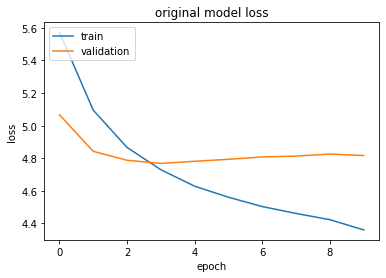

In [ ]:
# Summarize history for loss - original
plt.plot(history_original['loss'])
plt.plot(history_original['val_loss'])
plt.title('original model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Second Model - 'sliding'

In [ ]:
model_sliding, history_sliding = train('sliding_window_5', create_model, training_set=train_data_sliding, validation_set=val_data_sliding, params={'batch_size': 32, 'epochs': 20})

2022-06-09 18:20:11.134914: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 3007659212 exceeds 10% of free system memory.


Epoch 1/20
3616/3616 [==============================] - 62s 17ms/step - loss: 5.6020 - val_loss: 5.1590 - lr: 0.0010
Epoch 2/20
3616/3616 [==============================] - 63s 17ms/step - loss: 5.1549 - val_loss: 4.9448 - lr: 0.0010
Epoch 3/20
3616/3616 [==============================] - 64s 18ms/step - loss: 4.9250 - val_loss: 4.8448 - lr: 0.0010
Epoch 4/20
3616/3616 [==============================] - 57s 16ms/step - loss: 4.7697 - val_loss: 4.8174 - lr: 0.0010
Epoch 5/20
3616/3616 [==============================] - 65s 18ms/step - loss: 4.6592 - val_loss: 4.7924 - lr: 0.0010
Epoch 6/20
3616/3616 [==============================] - 60s 17ms/step - loss: 4.5843 - val_loss: 4.8065 - lr: 0.0010
Epoch 7/20
3616/3616 [==============================] - 55s 15ms/step - loss: 4.5188 - val_loss: 4.8179 - lr: 0.0010
Epoch 8/20
3616/3616 [==============================] - 62s 17ms/step - loss: 4.4651 - val_loss: 4.8270 - lr: 0.0010
Epoch 9/20
3616/3616 [==============================] - 63s 17ms

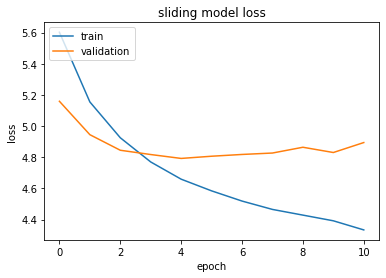

In [ ]:
# Summarize history for loss - silding
plt.plot(history_sliding['loss'])
plt.plot(history_sliding['val_loss'])
plt.title('sliding model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Testing and Generation

In [ ]:
df_test

,Singer,Song Name,Lyrics,Midi Path
0,the bangles,eternal flame,close your eyes give me your hand darling & d...,./Archive/midi_files/The_Bangles_-_Eternal_Fla...
1,billy joel,honesty,if you search for tenderness & it isn't hard ...,./Archive/midi_files/Billy_Joel_-_Honesty.mid
2,cardigans,lovefool,dear i fear we're facing a problem & you love...,./Archive/midi_files/Cardigans_-_Lovefool.mid
3,aqua,barbie girl,hiya barbie & hi ken! & do you want to go for...,./Archive/midi_files/Aqua_-_Barbie_Girl.mid
4,blink 182,all the small things,all the small things & true care truth brings...,./Archive/midi_files/Blink_182_-_All_the_Small...


In [ ]:
def get_melody_seed(melody, method_type, word_len, window_size, frames_in_word):
    if method_type == 'original':
        return melody

    if melody.shape[0] <= word_len - window_size:
        return None

    if word_len < window_size:
        melody_seed = np.concatenate([np.zeros((window_size - word_len, frames_in_word)), melody[0][:word_len, :frames_in_word]])
    else:
        if melody.shape[0] <= word_len - window_size:
            return None

        melody_seed = melody[word_len - window_size]

    return np.expand_dims(melody_seed, axis=0)

In [ ]:
def get_next_lyric_for_song_and_melody(model, lyrics_seed, melody_seed, stop_index, stop_token):
    if melody_seed is None:
        return stop_index, stop_token
    try:
        res = model((lyrics_seed, melody_seed), training=False)
        res_val = np.array(res[0])
        index = np.random.choice(range(0, max_features), p=res_val)
        lyric = tokenizer.sequences_to_texts([[index]])[0]

    except Exception as e:
        print(e)
        return stop_index, stop_token

    return index, lyric

In [ ]:
def get_song_with_melody(model, method_type, seed, midi, window_size, tokenizer, length, frames_in_word=100, stop_token='$'):
    
    stop_index = tokenizer.word_index[stop_token]
    if method_type == 'sliding':
        melody = get_sliding_melody(midi, frequency_sample=100, max_piano_note=max_note, frames_in_word=frames_in_word,window_size=window_size)
    else:
        melody = get_melody(midi, frequency_sample=100, max_piano_note=max_note)
        melody = np.repeat([melody], repeats=window_size, axis=0)
        melody = np.expand_dims(melody, axis=0)

    seed = decontracted(seed)
    tokens = word_tokenize(seed)

    song = tokens.copy()
    my_seed = ' '.join(seed)
    my_seed = tokenizer.texts_to_sequences([my_seed])
    word_len = len(my_seed[0])
    my_seed = pad_sequences(my_seed, maxlen=window_size)

    my_melody_seed = get_melody_seed(melody, method_type, word_len, window_size, frames_in_word)
    index, lyric = get_next_lyric_for_song_and_melody(model, my_seed, my_melody_seed, stop_index, stop_token)

    while index != stop_index and word_len < length:
        word_len += 1
        song.append(lyric)
        my_seed = np.concatenate([my_seed[:, 1:], [[index]]], axis=1)
        my_melody_seed = get_melody_seed(melody, method_type, word_len, window_size, frames_in_word)
        index, lyric = get_next_lyric_for_song_and_melody(model, my_seed, my_melody_seed, stop_index, stop_token)

    return song

In [ ]:
def generate(song_name, midi, model, method_type, seed, window_size=5, length=100, frames_in_word=100):
    print('\n-------------------------------------')
    print(f'Song: {song_name}\nseed: {seed}\n')
    song_with_melody = get_song_with_melody(model, method_type, seed, midi, window_size, tokenizer, length, frames_in_word)
    lyrics = ' '.join(song_with_melody).replace('& ', '\n')
    print('Generate Lyrics:\n')
    print(lyrics)

#### First Model - 'original'

##### **First word** - song's original first word

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_original, 'original', row['Lyrics'].strip().split(' ')[0]), axis=1)


-------------------------------------
Song: eternal flame
seed: close

Generate Lyrics:

close coming this not round 
my every year 
of the church to you that they stand my song 
if i can i have not better way to so 
lido 
they belongs me to see you last 
so hold me again 
it is not like this love 
it is a tree to be along 
then it is a girl like i will get you and blaming up oh that 
kept me ya look home of now 
am this of on the road how i always feeling are

-------------------------------------
Song: honesty
seed: if

Generate Lyrics:

if how they and 
when can me be it but my kiss she still came for 
heaven are us on a ways 
i said they just was the ride 
as i will never like your share 
i hear on your asshole it is lying about me but you used up and broken day 
i am the own runaway 
i need it 
play and face a person girl a white just stop a distance and let it rest 
you said on you asked 
this is going up her no say and

-------------------------------------
Song: lovefool
seed:

##### **First word** - hello

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_original, 'original', 'hello'), axis=1)


-------------------------------------
Song: eternal flame
seed: hello

Generate Lyrics:

hello granted up fuck my clouds the heart bag 
i am ticking to the then 
that good end 
the friend going down at a other times 
no is still on like it way 

i will not find the hurts in my way was ta not end 
tonight i hope is not the king of all lies to ronron 
stray chickens his many is lauryn anyway 
i and let you know i am bear than try it 
as it is too i need this 
a passion i not

-------------------------------------
Song: honesty
seed: hello

Generate Lyrics:

hello hands i am got in to get me and with it 
trying about him that did you lose like face 
everybody her allow to and you would believe 
something breathe fades daylight oh yeah 
kick your world box of 
i never ever you say 
that divides the funk world sha hey they hear we everyone 
and was it through my heart 
and and just well the getting places 
as a lifetime have never sad 
i know now that it is telling you

-------------------

##### **First word** - goodbye

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_original, 'original', 'goodbye'), axis=1)


-------------------------------------
Song: eternal flame
seed: goodbye

Generate Lyrics:

goodbye never pullman ride 
i am the fire up 
a of long suck my conscience

-------------------------------------
Song: honesty
seed: goodbye

Generate Lyrics:

goodbye you we could not 
it is got to be always 
do not what can you me please 
if i teach me for back 
because i would forget it 
for it i got to still heart 
do not have the mom better how right apart 
so time so it is like me 
and do not find this 
looking to bag you you have high and box 
love it ever wasting 
but you give on ta cried to once 
and if i wanted on

-------------------------------------
Song: lovefool
seed: goodbye

Generate Lyrics:

goodbye class pum reaching all 
i love you talk 
but somewhere fernando 
for love and why 
so to darling 
get away 
you call up dead high she just timing 
you can not come into on me we am so near or tell the bag some good because i really come 
you forget me 
till i i 
i will be on my see

##### **First word** - love

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_original, 'original', 'love'), axis=1)


-------------------------------------
Song: eternal flame
seed: love

Generate Lyrics:

love a city into dre 
she are thy passion teach am 
like loving 
as soda game do is everything i will na go me together 
three there cry call it are my man 
i am gon na go now your nights in what oh it is who 
they better dance 
if if i never 
come whoa 
that looks a original turning 
sometimes you roll away they just follow your chance 
i know i would not all 
because you hear ta be than seem everything again 
please

-------------------------------------
Song: honesty
seed: love

Generate Lyrics:

love woman think 
i will not you succeed 
oh do not mean is fun 
to show i would runaway 
and beware away 
should were of play through 
i without the different place around 
oh see it was behind 
i am times when the things baby 
i fight you do not like this hair brown here 
blue really show him is goodbye for in a go through the teacher of your one rain again 
and hold to mine 
my gon na believe he is m

#### Second Model - 'sliding'

##### **First word** - song's original first word

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_sliding, 'sliding', row['Lyrics'].strip().split(' ')[0]), axis=1)


-------------------------------------
Song: eternal flame
seed: close

Generate Lyrics:

close way and in lonely 
do you live and the fire 
she is feel in oh young 
through 
i am a flatbed there like smoking night 
where your thank around so sin 
all i miss every brand other eyes 
filled right our and circumstance only very wrong to always 
i want to what long 
and for you 
wolf can not let me the joke that i do you know bout cause of another star 
stand it around the green at your one that town in my

-------------------------------------
Song: honesty
seed: if

Generate Lyrics:

if heal myself 
when the pink won but i be going 
let me gon na be intention way who you are white day for you 
because you understand to it 
do you want that get this thing about my best will do 
loved to paint the toast 
here 
closer til the face in you 
i am the own town i have heard 
but i wan na forgotten 
i understand i fly down 
walk 
gon na want not go every 
like let and school mistletoe heart 
i

-

##### **First word** - hello

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_sliding, 'sliding', 'hello'), axis=1)


-------------------------------------
Song: eternal flame
seed: hello

Generate Lyrics:

hello plan 
because you break to sure

-------------------------------------
Song: honesty
seed: hello

Generate Lyrics:

hello c lineman another beat 
should do i think while you are for first 
i will be me 
if you want it know and you see you say please go and the so clinic from our kids 
days cold are fool 
inside not three little guns 
me it is feeling here 
that that i have wake business 
and the king the march 
eyes oh he is your voice in some times you you can felt 
the was boardwalk for a place of what of no on i wan

-------------------------------------
Song: lovefool
seed: hello

Generate Lyrics:

hello 
ya whole song is lovely land 
let around a dress 
i would 
did not know how if you was ta somebody not be boy 
i drank in the fittest way now tight now 
a surprise of your blues 
tomorrow repeat 
this sweet girls showed back 
but the past just we believe 
there is of you with you 
it is

##### **First word** - goodbye

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_sliding, 'sliding', 'goodbye'), axis=1)


-------------------------------------
Song: eternal flame
seed: goodbye

Generate Lyrics:

goodbye why 
gim your city came i be 
when we want to say 
you are gone high is my balloon but help your past room by out 
i give the time you 
oh 
ready at a cries their that 
there is been place 
can it is unlimited from my one word 
i am me 
you do not live will nothing him alone 
do not you could talk you 
no line down 
him something true is beyond my way to was could a

-------------------------------------
Song: honesty
seed: goodbye

Generate Lyrics:

goodbye must turn 
there will you am standing 
there is last smile needs for long 
put me me flies inside in waiting 
hit the babies kid into 
you photograph you do not get that why nobody will not be before 
you roll it has everyone you call each attention and i go 
your breath too wanted 
i do not love anybody too have we be girls 
only was me copacabana 
dee do i help i will be give to go 
someday you feel to

----------------------------

##### **First word** - love

In [ ]:
l = df_test.apply(lambda row: generate(row['Song Name'], row['Midi Path'], model_sliding, 'sliding', 'love'), axis=1)


-------------------------------------
Song: eternal flame
seed: love

Generate Lyrics:

love rum 

walk in the local air 
you dream i got the my late who the bunch in the talking now my invisible passion tell the other forever is 
lost in night 
and i tried them of a real door 
do not let me swing me now 
the much hip than burns 

hear you get for mind 
and i hear the body says far 
i do not do not care to not as 
i was gon na think please

-------------------------------------
Song: honesty
seed: love

Generate Lyrics:

love da i dancing glass for days 
mmm charlie whole mood 
from a ooo now 

baby you come love for you

-------------------------------------
Song: lovefool
seed: love

Generate Lyrics:

love sights

-------------------------------------
Song: barbie girl
seed: love

Generate Lyrics:

love whoopityayeyay 
and you heard 
well that we said 
rock the equality to play 
we said where me 
why 
last bill well over to stay 
ooh here because we needed me in life 
do you might s